/tmp/ipykernel_13935/3509530699.py:36: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_avg_u = np.average(df1['u'].append(df2['u']))
/tmp/ipykernel_13935/3509530699.py:37: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_avg_y = np.average(df1['y'].append(df2['y']))
/tmp/ipykernel_13935/3509530699.py:38: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_std_u = np.std(df1['u'].append(df2['u']))
/tmp/ipykernel_13935/3509530699.py:39: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_std_y = np.std(df1['y'].append(df2['y']))


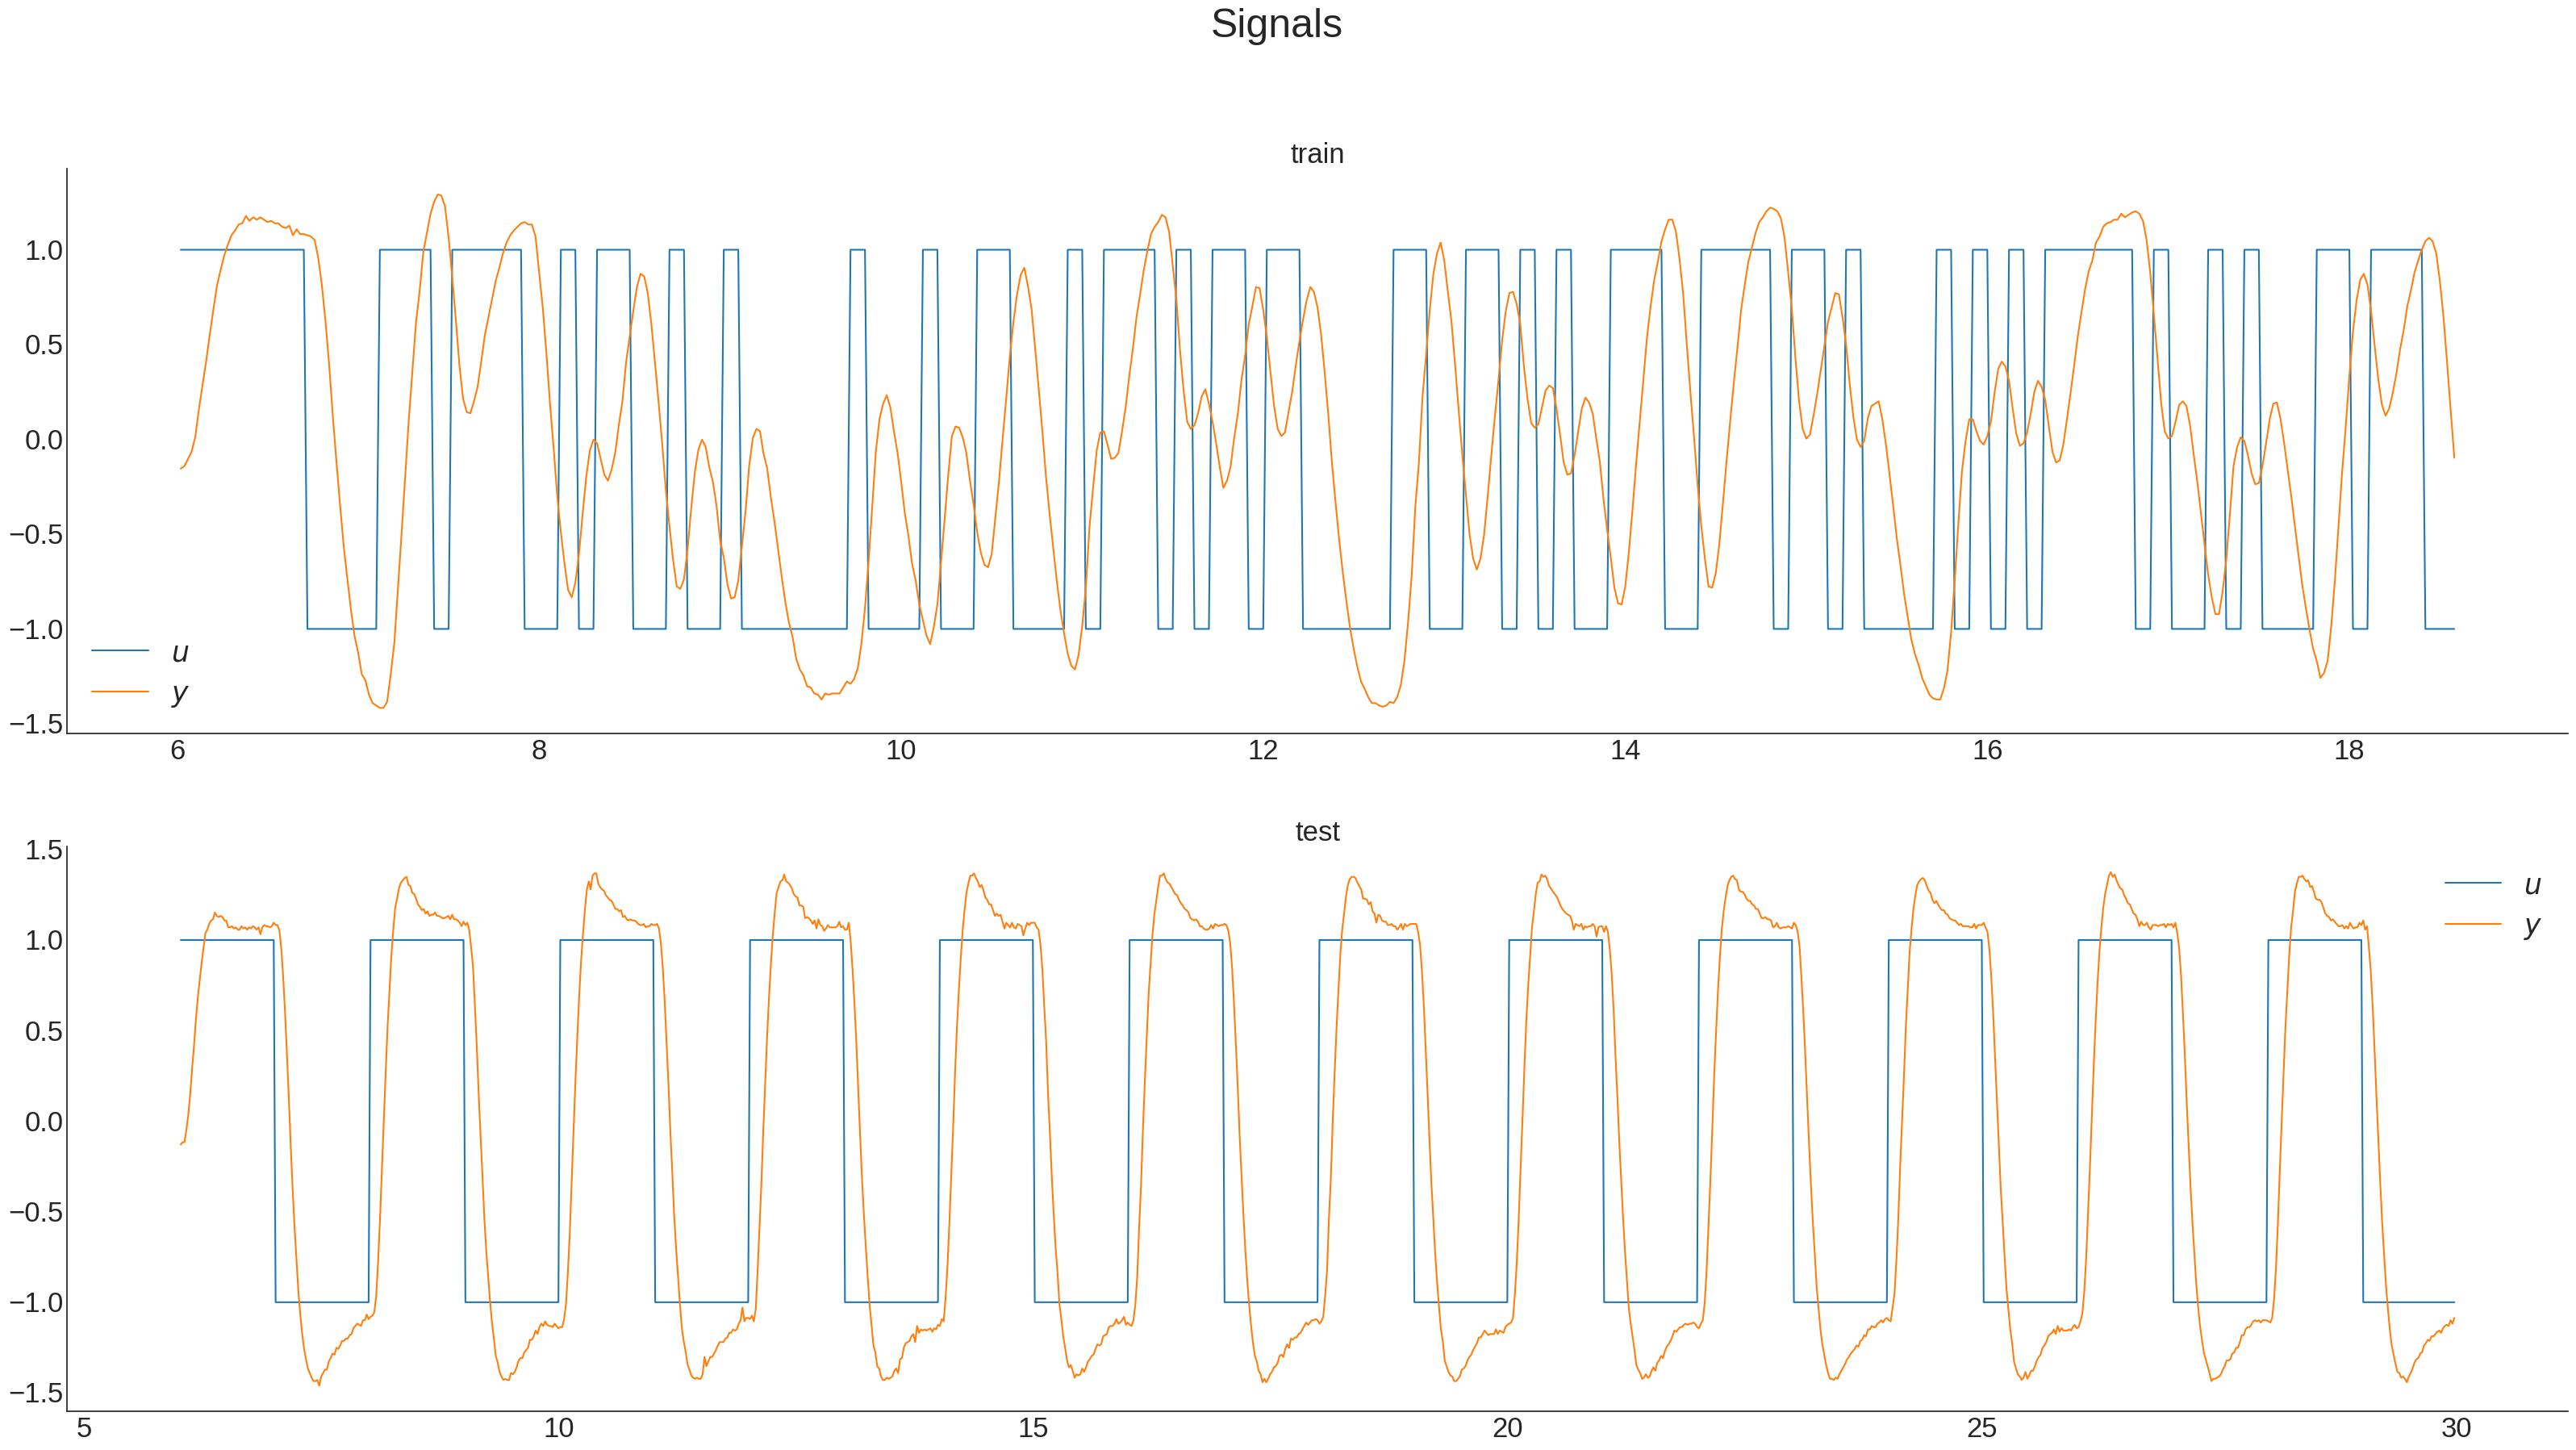

In [107]:
import copy
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import impulse, lti, step, butter, lfilter, welch
#import sysidentpy as sipy
from scipy.fft import fft, ifft, fftshift

from sysidentpy.metrics import mean_squared_error
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation

plt.rc('font', size=30)          # controls default text sizes
plt.rc('axes', titlesize=25)     # fontsize of the axes title
plt.rc('axes', labelsize=25)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels
plt.rc('legend', fontsize=25)    # legend fontsize

df1 = pd.read_csv('data/U3.ASC', sep="\s+", names=['time', 'y', 'u'])
df2 = pd.read_csv('data/U1.ASC', sep="\s+", names=['time', 'y', 'u'])

# z-normalize the signals
def z(x):
    x = np.asarray(x)
    return (x-np.average(x)) / np.std(x)

# cut
df1 = df1.iloc[301:1500]
df2 = df2.iloc[301:930]

# z-normalise
joint_avg_u = np.average(df1['u'].append(df2['u']))
joint_avg_y = np.average(df1['y'].append(df2['y']))
joint_std_u = np.std(df1['u'].append(df2['u']))
joint_std_y = np.std(df1['y'].append(df2['y']))
df1['u'] = (df1['u']-joint_avg_u)/joint_std_u
df1['y'] = (df1['y']-joint_avg_y)/joint_std_y
df2['u'] = (df2['u']-joint_avg_u)/joint_std_u
df2['y'] = (df2['y']-joint_avg_y)/joint_std_y

x_train = np.asarray(df2['u']).reshape(-1,1)
x_valid = np.asarray(df1['u']).reshape(-1,1)
y_train = np.asarray(df2['y']).reshape(-1,1)
y_valid = np.asarray(df1['y']).reshape(-1,1)

fig, axn = plt.subplots(2,1,figsize=(40,20))
title = 'Signals'
fig.suptitle(title)
axn[0].plot(df2['time'], x_train, label=r'$u$')
axn[0].plot(df2['time'], y_train, label=r'$y$')
axn[0].set_title('train')
axn[0].legend()
axn[1].plot(df1['time'], x_valid, label=r'$u$')
axn[1].plot(df1['time'], y_valid, label=r'$y$')
axn[1].set_title('test')
axn[1].legend()
#plt.savefig('figs/{}.eps'.format(title))
plt.show()


# Basic implementation of ARX model

In [ ]:
ylag = 200
ulag = 200
lag = max(ulag,ylag)

model = FROLS(
    ylag=ylag,
    xlag=ulag,
    # n_terms=ylag+ulag,
    order_selection=True,
    info_criteria='aic', # Akaike Information Criterion
    n_info_values=ylag+ulag,
    estimator='least_squares',
    extended_least_squares=False,
    basis_function=Polynomial(degree=1) # linear
)
model.fit(X=x_train, y=y_train)

yhat_train = model._n_step_ahead_prediction(X=x_train, y=y_train[:lag], steps_ahead=len(y_train)-lag)
yhat_valid = model._n_step_ahead_prediction(X=x_valid, y=y_valid[:lag], steps_ahead=len(y_valid)-lag)

mse_train = mean_squared_error(y_train[lag:], yhat_train)
mse_valid = mean_squared_error(y_valid[lag:], yhat_valid)

fig, axn = plt.subplots(2,1,figsize=(40,20))
title = 'ARMAX ulag={}, ylag={}'.format(ulag, ylag)
fig.suptitle(title)
axn[0].plot(df2['time'][lag:], yhat_train, label=r'$\hat{y}$')
axn[0].plot(df2['time'][lag:], y_train[lag:], label=r'$y$')
axn[0].set_title('train')
axn[0].legend(loc=2)
axn[0].text(0.01, 0.05, 'mse={}'.format(round(mse_train,6)), transform=axn[0].transAxes, verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axn[1].plot(df1['time'][lag:], yhat_valid, label=r'$\hat{y}$')
axn[1].plot(df1['time'][lag:], y_valid[lag:], label=r'$y$')
axn[1].set_title('test')
axn[1].legend(loc=2)
axn[1].text(0.01, 0.05, 'mse={}'.format(round(mse_valid,6)), transform=axn[1].transAxes, verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
#plt.savefig('figs/{}.eps'.format(title))
plt.show()

r = pd.DataFrame(
    results(
        model.final_model, model.theta, model.err,
        model.n_terms, err_precision=8, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
print(r)

/home/kreljo/anaconda3/lib/python3.9/site-packages/sysidentpy/utils/deprecation.py:37: FutureWarning: Passing a string to define the estimator will rise an error in v0.4.0. 
 You'll have to use FROLS(estimator=LeastSquares()) instead. 
 The only change is that you'll have to define the estimator first instead of passing a string like 'least_squares'. 
 This change will make easier to implement new estimators and it'll improve code readability.
  warnings.warn(message, FutureWarning)


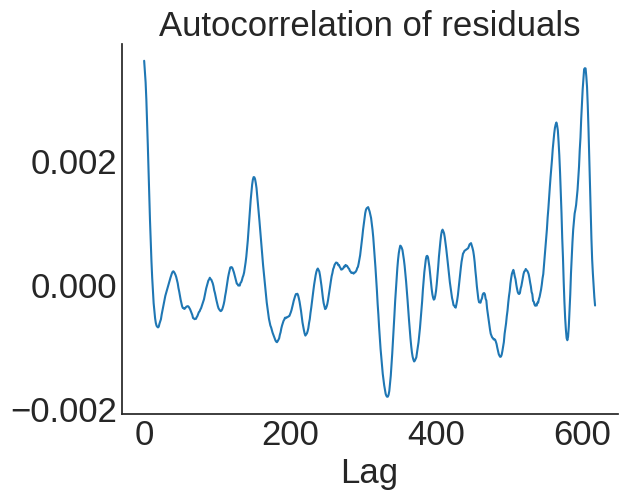

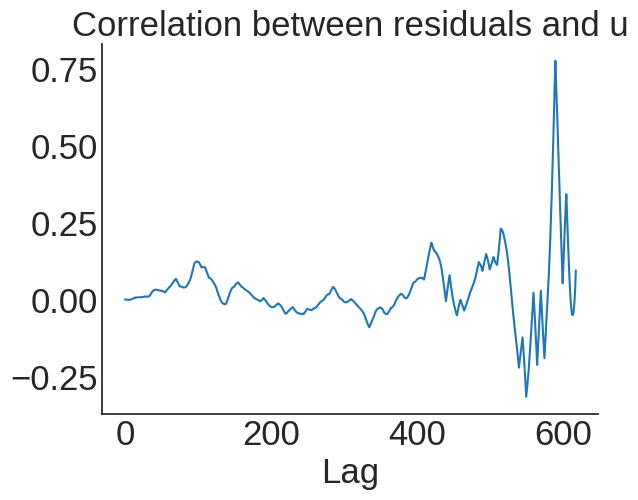

In [131]:
# ee = compute_residues_autocorrelation(y_train[lag:], yhat_train)
# plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")


e_train = (yhat_train - y_train[lag:]).reshape(-1)

cc = []
l = len(e_train)
for i in range(len(e_train)):
    cc.append(np.sum(1 / (l-i) * e_train[:l-i] * e_train[i:]))
# cross_correlation = np.convolve(e_train, e_train, mode='same')
# cross_correlation /= np.max(cross_correlation)

plt.plot(cc)
plt.title('Autocorrelation of residuals')
plt.xlabel('Lag')
plt.show()

cc = []
l = len(e_train)
for i in range(len(e_train)):
    cc.append(np.sum(1 / (l-i) * e_train[:l-i] * x_train[i:]))
# cross_correlation = np.convolve(e_train, x_train[lag:,0], mode='same')
# cross_correlation /= np.max(cross_correlation)

plt.plot(cc)
plt.title('Correlation between residuals and u')
plt.xlabel('Lag')
plt.show()